In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import splu
from scipy.special import erf
import warnings
import logging

def assemble_poisson_matrix_neumann(nrows, ncols, hx, hy, eps_in):
    A = lil_matrix((nrows * ncols, nrows * ncols))
    eps = eps_in.ravel()[:]
    for i in range(0,nrows):
        for j in range(0,ncols):
            k = i * ncols + j


            if j == 0 and (i != 0 and i != nrows - 1):
                A[k, k] = -0.5 * (eps[k+1] + eps[k+1] + 2 * eps[k]) / hx**2 - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
                A[k, k + 1] = 2 / hx**2 * (eps[k] + eps[k+1]) * 0.5
                A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5
                A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5
                continue

            if (i == 0 or i == nrows - 1 or j == ncols - 1):
                A[k, k] = 1
                continue
                
            A[k, k] = -0.5 * (eps[k-1] + eps[k+1] + 2 * eps[k]) / hx**2 - 0.5 * (eps[k-ncols] + eps[k+ncols] + 2 * eps[k]) / hy**2
            A[k, k + 1] = 1 / hx**2 * (eps[k] + eps[k+1]) * 0.5
            A[k, k - 1] = 1 / hx**2 * (eps[k] + eps[k-1]) * 0.5
            A[k, k + ncols] = 1 / hy**2 * (eps[k] + eps[k+ncols]) * 0.5
            A[k, k - ncols] = 1 / hy**2 * (eps[k] + eps[k-ncols]) * 0.5

    return splu(A.tocsc())

def compute_electric_field(n_e, n_h, params):
    # compute electric field
    q_e = 1.6e-19
    epsilon_0 = 8.854e-18

    rho = (n_e - n_h) * q_e

    # rho[:,0] = 0 # Left boundary
    rho[:,-1] = 0 # Right boundary
    rho[0,:] = 0  # Bottom boundary
    rho[-1,:] = 0 # Top boundary

    b = rho.ravel()[:] / epsilon_0 
    
    # phi = spsolve(params['A'], b).reshape(params['X'].shape)

    phi = params['A'].solve(b).reshape(params['X'].shape)

    ey, ex = np.gradient(-phi, params['hy'], params['hx'])

    return ex, ey

def compute_current_gradient_term(n_e, n_h, params):

    # compute electric field
    ex, ey = compute_electric_field(n_e, n_h, params)
    # calculate j
    ne_dy, ne_dx = np.gradient(n_e, params['hy'], params['hx'])

    j_diff_x = params['diff'] * ne_dx
    j_diff_y = params['diff'] * ne_dy

    j_drift_x = n_e * params['mu'] * ex
    j_drift_y = n_e * params['mu'] * ey

    j_x = j_diff_x + j_drift_x
    j_y = j_diff_y + j_drift_y

    j_x[:, 0] = j_x[:, 1]

    _, grad_jx_dx = np.gradient(j_x, params['hy'], params['hx'])
    grad_jy_dy, _ = np.gradient(j_y, params['hy'], params['hx'])

    if params['print_tag']:
        plt.imshow(j_x, extent=[params['x'][0], params['x'][-1], params['y'][0], params['y'][-1]], 
                            origin='lower', aspect=0.5*params['Lx']/params['Ly'], cmap='Spectral')
        plt.colorbar()
        plt.show()
        params['print_tag'] = False

    return grad_jx_dx + grad_jy_dy

def compute_source_term(t, params):

    # Unpack parameters
    nc = params['nc']
    alpha = params['alpha']
    sigma_y = params['sigma_y']
    sigma_t = params['sigma_t']
    t0 = params['t0']
    X = params['X']
    Y = params['Y']
    # Calculate the source term
    source_term = (nc * alpha / (2 * np.sqrt(2) * np.pi**(3/2) * sigma_y**2 * sigma_t) *
                   np.exp(-alpha * X) *
                   np.exp(-(Y**2) / (2 * sigma_y**2)) *
                   np.exp(-((t - t0)**2) / (2 * sigma_t**2)))
    
    return source_term

def compute_decay_term(n, params):

    return params['gamma'] * n

def dndt(t, n_e, n_h, params):

    current_gradient_term = compute_current_gradient_term(n_e, n_h, params)

    generation_term = compute_source_term(t, params)

    decay_term = compute_decay_term(n_e, params)

    return current_gradient_term + generation_term - decay_term

def dpdt(t, n_h, params):


    generation_term = compute_source_term(t, params)

    decay_term = compute_decay_term(n_h, params)

    return generation_term - decay_term

def solve_drift_diffusion(n_e_0, n_h_0, params):
    
    # Set up logging configuration
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    n_e = n_e_0
    n_h = n_h_0
    dt = params['dt']
    t = 0

    for n in range(params['Nt']//2):

        k1 = dt * dndt(t, n_e, n_h, params)
        p1 = dt * dpdt(t, n_h, params)

        k2 = dt * dndt(t + dt / 2, n_e + k1 / 2, n_h + p1 / 2, params)
        p2 = dt * dpdt(t + dt / 2, n_h + p1 / 2, params)

        k3 = dt * dndt(t + dt / 2, n_e + k2 / 2, n_h + p2 / 2, params)
        p3 = dt * dpdt(t + dt / 2, n_h + p2 / 2, params)

        k4 = dt * dndt(t + dt, n_e + k3, n_h + p3, params)
        p4 = dt * dpdt(t + dt, n_h + p3, params)
        
        n_e = n_e + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        n_h = n_h + (p1 + 2 * p2 + 2 * p3 + p4) / 6

        if np.any(n_e < 0):
            warnings.warn("Warning: n_e contained values less than zero, setting them to 0.", stacklevel=2)
            n_e[n_e < 0] = 0
        if np.any(np.isinf(n_e)):
            warnings.warn("Warning: n_e contained infinity (inf) values, setting them to 0.", stacklevel=2)
            n_e[np.isinf(n_e)] = 0
        if np.any(np.isnan(n_e)):
            warnings.warn("Warning: n_e contained NaN values, setting them to 0.", stacklevel=2)
            n_e[np.isnan(n_e)] = 0

                # Log progress every 300 time steps
        if n % 50 == 0:
            logger.info(f"Progress: time step {n}, time {t:.2f}")
            params['print_tag'] = True

        t += dt


INFO:__main__:Progress: time step 0, time 0.00


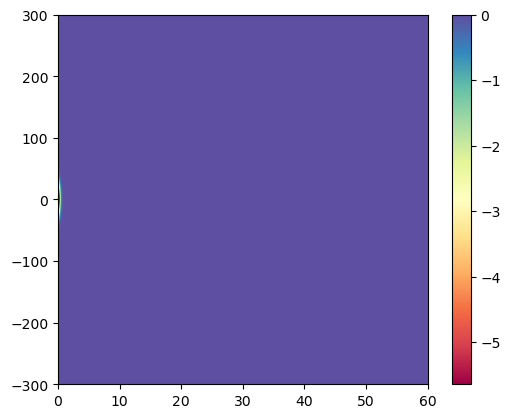

INFO:__main__:Progress: time step 50, time 0.00


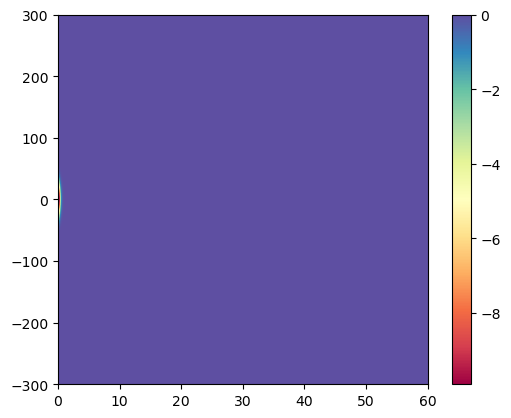

INFO:__main__:Progress: time step 100, time 0.00


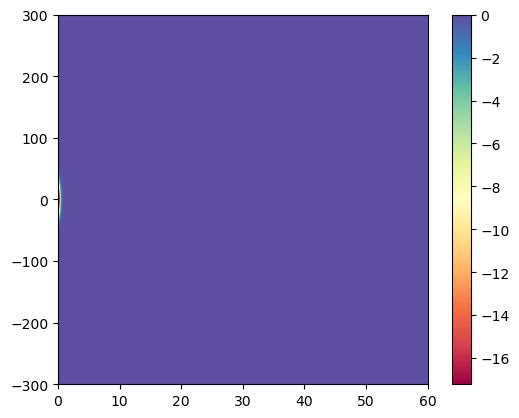

INFO:__main__:Progress: time step 150, time 0.01


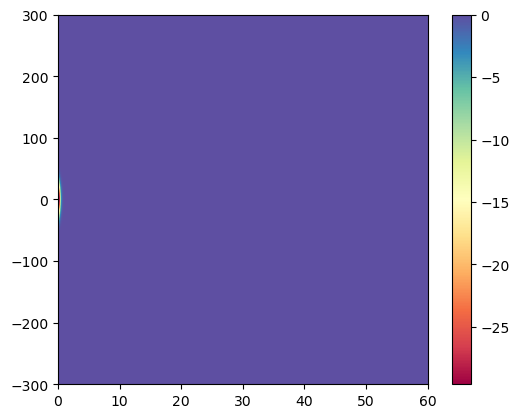

INFO:__main__:Progress: time step 200, time 0.01


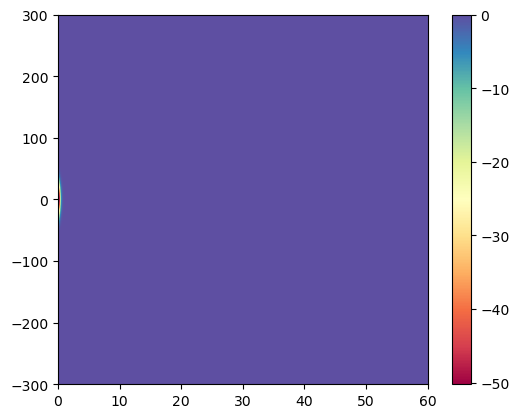

INFO:__main__:Progress: time step 250, time 0.01


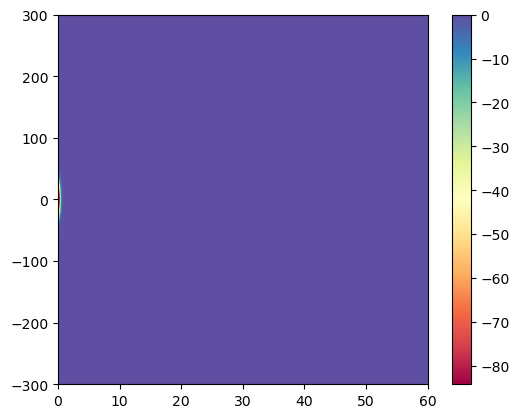

KeyboardInterrupt: 

In [ ]:

if __name__ == '__main__':
    
    # output_dir = './current_densities/eps12/'
    # if not os.path.exists(output_dir):
    #     os.makedirs(output_dir)

    params = {
        "nc": 4e9,
        "alpha": 7,
        "gamma": 3.3,
        "sigma_y": 40 / np.sqrt(8 * np.log(2)),
        "diff": 0.1,
        "mu": 4,
        "t_r": 4e3,
        "sigma_t": (50 / np.sqrt(8 * np.log(2))) * 1e-3,
        "t0": 0.1,
        
        "Lx": 60,
        "Ly": 300,
        "T": 1,
        "Nx": 1000,
        "Ny": 250,
        "Nt": 20000,

        "print_tag" : False
    }

    params["dt"] = 1 / params["Nt"]     
    params["x"] = np.linspace(0, params['Lx'], params['Nx'])
    params["y"] = np.linspace(-params['Ly'], params['Ly'], params['Ny'])
    
    params['hx'] = params['x'][1] - params['x'][0]
    params['hy'] = params['y'][1] - params['y'][0]
    params['X'], params['Y'] = np.meshgrid(params['x'], params['y'])

    params['eps'] = np.ones(params['X'].shape) * 12
    params['nrows'], params['ncols'] = params['X'].shape

    if params['diff'] * params['dt'] / params['hx']**2 > 0.5 or params['diff'] * params['dt'] / params['hy']**2 > 0.5:
        raise ValueError('The solution is unstable. Reduce dt or increase dx and dy.')
    
    params['A'] = assemble_poisson_matrix_neumann(params['nrows'], params['ncols'], params['hx'], params['hy'], params['eps'])

    def cumulative_generated_carriers(t, params):
    # Calculate the expression
        return (np.exp(-params['X'] * params['alpha'] - params['Y']**2 / (2 * params['sigma_y']**2)) * params['nc'] * params['alpha'] * (1 + erf((t - params['t0']) / (np.sqrt(2) * params['sigma_t']))) / (4 * np.pi * params['sigma_y']**2))



    n_e_0 = cumulative_generated_carriers(0, params)
    n_h_0 = cumulative_generated_carriers(0, params)

    solve_drift_diffusion(n_e_0, n_h_0, params)
